In [3]:
import h5py
h5_path = 'legacy_flux_embeddings.h5'
file = h5py.File(h5_path)
print(file.keys())
for key in file.keys():
    print('#------------',key,'-------------#')
    if 'flux' not in key:
        print(type(file[key]))
        print(file[key],'\n')


<KeysViewHDF5 ['astrodino_3z_7e5_vit_base_embedding', 'astrodino_3z_7e5_vit_large_embedding', 'flux']>
#------------ astrodino_3z_7e5_vit_base_embedding -------------#
<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "astrodino_3z_7e5_vit_base_embedding": shape (100000, 768), type "<f4"> 

#------------ astrodino_3z_7e5_vit_large_embedding -------------#
<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "astrodino_3z_7e5_vit_large_embedding": shape (100000, 1024), type "<f4"> 

#------------ flux -------------#


## check vit base

In [8]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor

# filepath: /ptmp/yacheng/outthere_ssl/AstroCLIP/astroclip/astrodino/photometry/photometry.ipynb
print('reading files from',h5_path)
hf = h5py.File(h5_path, "r")

model_group = "astrodino_3z_7e5_vit_base_embedding"  # embeddings
X = np.array(hf[model_group])
y = np.array(hf["flux"][:])  # shape: (N, num_bands)；for single channel e.g. 0: y = hf["flux"][:, 0]


print('converting flux to rgb via \'to_rgb\'')
def flux_to_rgb(flux, scale_z=2.2, m=0.03, Q=20.0):
    I = np.maximum(0.0, flux * scale_z + m)
    return np.arcsinh(Q * I) / np.sqrt(Q)
def inverse_flux_to_rgb(rgb, scale_z=2.2, m=0.03, Q=20.0):
    I = np.sinh(rgb * np.sqrt(Q)) / Q
    return np.maximum(0.0, (I - m) / scale_z)

y_trans = flux_to_rgb(y)  # shape (N,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_trans, test_size=0.1, random_state=0, shuffle=True)


regressor = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (   "mlp",
            MLPRegressor(
                hidden_layer_sizes=(128,128,128),
                activation="relu",
                solver="adam",
                learning_rate_init=5e-5,
                batch_size=256,
                max_iter=350,
                random_state=42,
                early_stopping=True,
                n_iter_no_change=8,
                verbose=False
                ),),])
print('starts training')
regressor.fit(X_train, y_train)
print('finished!')

reading files from legacy_flux_embeddings.h5
converting flux to rgb via 'to_rgb'
starts training
finished!


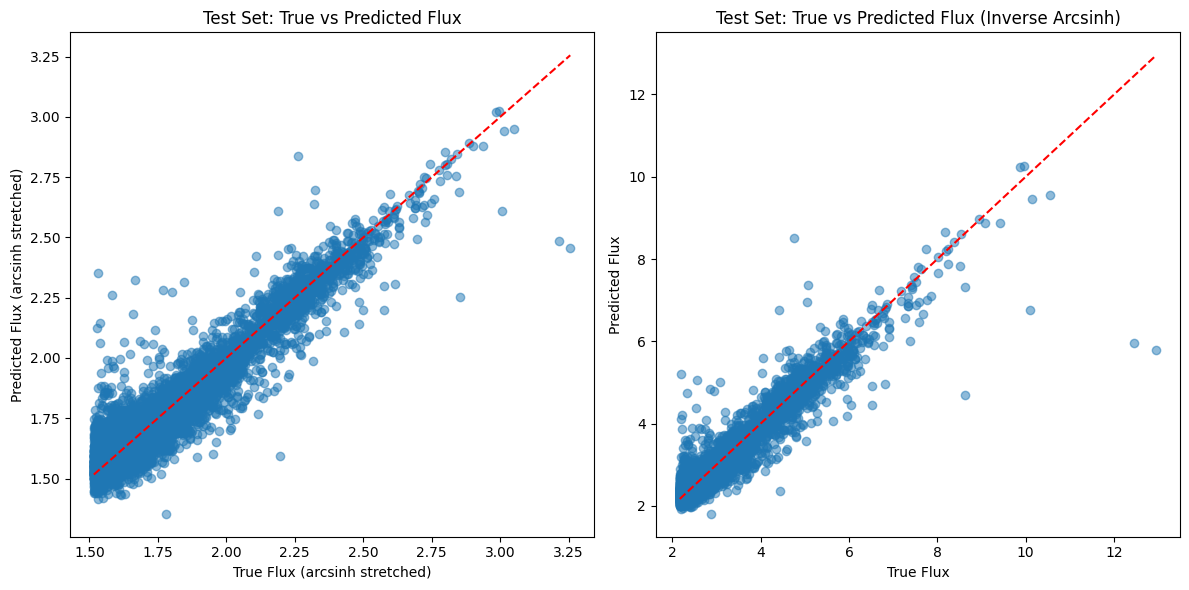

Train: R²=0.9488, MSE=0.0029, MAE=0.0374
Test: R²=0.9069, MSE=0.0051, MAE=0.0487
inversing rgb to mag
Test (mag): R²=0.9069, MSE=0.1203, MAE=0.2364


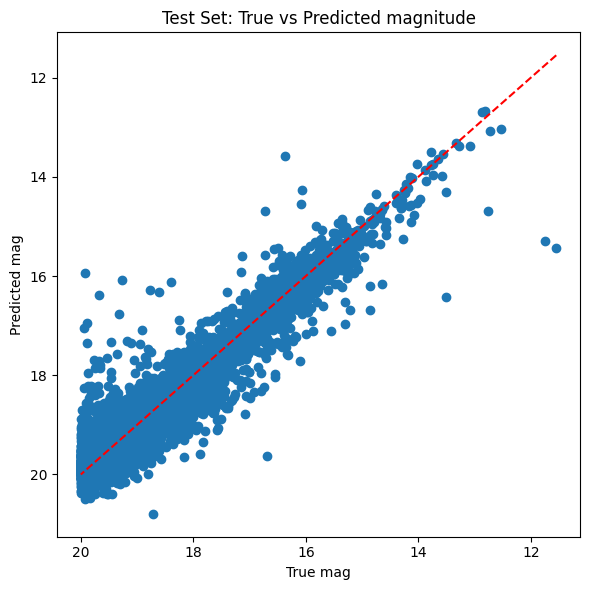

In [9]:
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

from matplotlib import pyplot as plt
from matplotlib import colors
#shwo 1x2 figures of arcsin stretched flux prediction vs inverse arcsin stretched true flux
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("True Flux (arcsinh stretched)")
plt.ylabel("Predicted Flux (arcsinh stretched)")
plt.title("Test Set: True vs Predicted Flux")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.subplot(1, 2, 2)
plt.scatter(np.sinh(y_test), np.sinh(y_test_pred), alpha=0.5)
plt.xlabel("True Flux")
plt.ylabel("Predicted Flux")
plt.title("Test Set: True vs Predicted Flux (Inverse Arcsinh)")
plt.plot([np.sinh(y_test).min(), np.sinh(y_test).max()], [np.sinh(y_test).min(), np.sinh(y_test).max()], 'r--')
plt.tight_layout()
plt.show()

def summarize_split(name, y_true, y_pred):
    print(
        f"{name}: R²={r2_score(y_true, y_pred):.4f}, "
        f"MSE={mean_squared_error(y_true, y_pred):.4f}, "
        f"MAE={np.mean(np.abs(y_true - y_pred)):.4f}"
    )

summarize_split("Train", y_train, y_train_pred)
summarize_split("Test", y_test, y_test_pred)

print('inversing rgb to mag')
y_test_pred_mag = -2.5 * np.log10(inverse_flux_to_rgb(y_test_pred))+22.5
y_test_mag= -2.5 * np.log10(inverse_flux_to_rgb(y_test))+22.5
summarize_split("Test (mag)", y_test_mag, y_test_pred_mag)

#now plot predicted vs true flux in hist2d
plt.figure(figsize=(6, 6))
plt.scatter(y_test_mag,y_test_pred_mag)
plt.xlabel("True mag")
plt.ylabel("Predicted mag")
plt.title("Test Set: True vs Predicted magnitude")
plt.plot([y_test_mag.min(), y_test_mag.max()], [y_test_mag.min(), y_test_mag.max()], 'r--')
#invert x, y axis
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## now check vit large

In [10]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.neural_network import MLPRegressor

# filepath: /ptmp/yacheng/outthere_ssl/AstroCLIP/astroclip/astrodino/photometry/photometry.ipynb
print('reading files from',h5_path)
hf = h5py.File(h5_path, "r")

model_group = "astrodino_3z_7e5_vit_large_embedding"  # embeddings
X = np.array(hf[model_group])
y = np.array(hf["flux"][:])  # shape: (N, num_bands)；for single channel e.g. 0: y = hf["flux"][:, 0]


print('converting flux to rgb via \'to_rgb\'')
def flux_to_rgb(flux, scale_z=2.2, m=0.03, Q=20.0):
    I = np.maximum(0.0, flux * scale_z + m)
    return np.arcsinh(Q * I) / np.sqrt(Q)
def inverse_flux_to_rgb(rgb, scale_z=2.2, m=0.03, Q=20.0):
    I = np.sinh(rgb * np.sqrt(Q)) / Q
    return np.maximum(0.0, (I - m) / scale_z)

y_trans = flux_to_rgb(y)  # shape (N,)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_trans, test_size=0.1, random_state=0, shuffle=True)


regressor = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (   "mlp",
            MLPRegressor(
                hidden_layer_sizes=(128,128,128),
                activation="relu",
                solver="adam",
                learning_rate_init=5e-5,
                batch_size=256,
                max_iter=350,
                random_state=42,
                early_stopping=True,
                n_iter_no_change=8,
                verbose=False
                ),),])
print('starts training')
regressor.fit(X_train, y_train)
print('finished!')

reading files from legacy_flux_embeddings.h5
converting flux to rgb via 'to_rgb'
starts training
finished!


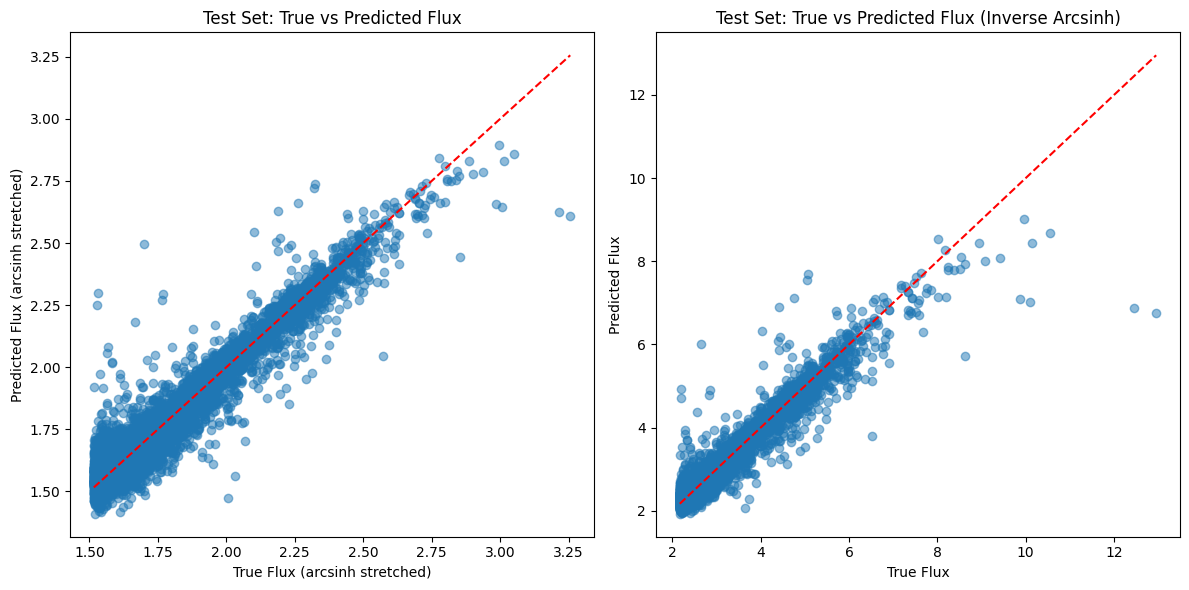

Train: R²=0.9606, MSE=0.0022, MAE=0.0319
Test: R²=0.9283, MSE=0.0039, MAE=0.0423
inversing rgb to mag
Test (mag): R²=0.9282, MSE=0.0927, MAE=0.2053


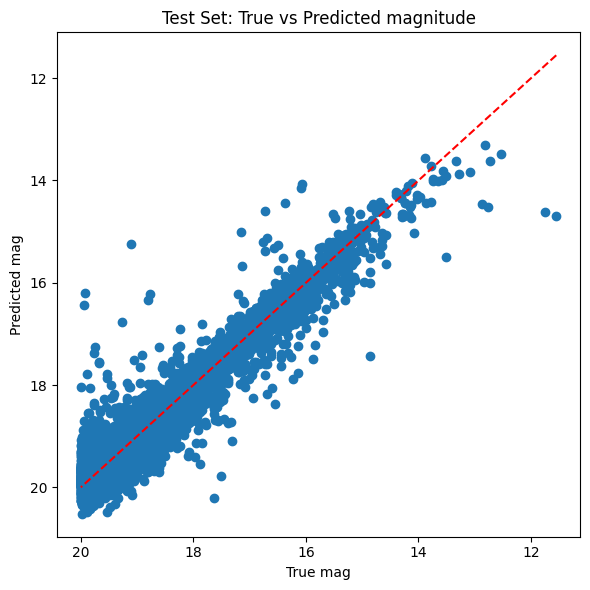

In [11]:
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

from matplotlib import pyplot as plt
from matplotlib import colors
#shwo 1x2 figures of arcsin stretched flux prediction vs inverse arcsin stretched true flux
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.xlabel("True Flux (arcsinh stretched)")
plt.ylabel("Predicted Flux (arcsinh stretched)")
plt.title("Test Set: True vs Predicted Flux")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.subplot(1, 2, 2)
plt.scatter(np.sinh(y_test), np.sinh(y_test_pred), alpha=0.5)
plt.xlabel("True Flux")
plt.ylabel("Predicted Flux")
plt.title("Test Set: True vs Predicted Flux (Inverse Arcsinh)")
plt.plot([np.sinh(y_test).min(), np.sinh(y_test).max()], [np.sinh(y_test).min(), np.sinh(y_test).max()], 'r--')
plt.tight_layout()
plt.show()

def summarize_split(name, y_true, y_pred):
    print(
        f"{name}: R²={r2_score(y_true, y_pred):.4f}, "
        f"MSE={mean_squared_error(y_true, y_pred):.4f}, "
        f"MAE={np.mean(np.abs(y_true - y_pred)):.4f}"
    )

summarize_split("Train", y_train, y_train_pred)
summarize_split("Test", y_test, y_test_pred)

print('inversing rgb to mag')
y_test_pred_mag = -2.5 * np.log10(inverse_flux_to_rgb(y_test_pred))+22.5
y_test_mag= -2.5 * np.log10(inverse_flux_to_rgb(y_test))+22.5
summarize_split("Test (mag)", y_test_mag, y_test_pred_mag)

#now plot predicted vs true flux in hist2d
plt.figure(figsize=(6, 6))
plt.scatter(y_test_mag,y_test_pred_mag)
plt.xlabel("True mag")
plt.ylabel("Predicted mag")
plt.title("Test Set: True vs Predicted magnitude")
plt.plot([y_test_mag.min(), y_test_mag.max()], [y_test_mag.min(), y_test_mag.max()], 'r--')
#invert x, y axis
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()